In [1]:
import json
import re
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from transformers import pipeline
from sentence_transformers import SentenceTransformer


# Descargar recursos de NLTK (solo la primera vez)
nltk.download('stopwords')
nltk.download('wordnet')

# Lista de rutas de archivos JSON (el usuario debe agregar las rutas aquí)
rutas_json = [
    ('Noticias_Contenido_Semana_Politica.json', "Semana"),
    ('Noticias_Contenido_Semana_Opinion.json', "Semana"),
    ('Noticias_Contenido_Semana_Economia.json', "Semana"),
    ('Noticias_Contenido_Colombiano.json', "Colombiano"),
    ('Noticias_Contenido_Silla_Vacia.json', "Silla_Vacia"),
    ('Noticias_CompletasCongresoElTiempo.json', "ElTiempo"),
    ('Noticias_CompletasProcesoPazElTiempo.json', "ElTiempo"),
    ('Noticias_CompletasPartidosPoliticosElTiempo.json', "ElTiempo"),
    ('Noticias_CompletasGobiernoElTiempo.json', "ElTiempo"),
    ('Espectador_Politica_Articulos.json', "Espectador"),
    ('Noticias_CompletasoOpinionTiempo.json', "ElTiempo")
# Agrega más rutas si es necesario
]

# Función para cargar y fusionar los JSON
def cargar_y_fusionar_json(rutas):
    datos_fusionados = []
    for ruta, fuente in rutas:
        with open(ruta, 'r', encoding='utf-8') as file:
            datos = json.load(file)
            for item in datos:
                item['fuente'] = fuente  # Agregar la fuente (nombre del archivo JSON)
            datos_fusionados.extend(datos)
    return datos_fusionados

# Cargar y fusionar los JSON
datos_fusionados = cargar_y_fusionar_json(rutas_json)

# Guardar datos_fusionados en un archivo JSON
with open('datos_fusionados.json', 'w', encoding='utf-8') as file:
    json.dump(datos_fusionados, file, ensure_ascii=False, indent=4)

# Preprocesamiento de texto
stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, list):
        text = ' '.join(text)
    if not isinstance(text, str):
        return ''
    text = re.sub(r'\W', ' ', text)  # Elimina caracteres especiales
    text = re.sub(r'\d+', '', text)  # Elimina números
    text = text.lower()  # Convertir a minúsculas
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Aplicar preprocesamiento a todos los textos
textos_procesados = [preprocess_text(item['content']) for item in datos_fusionados]

# Crear un DataFrame con los textos preprocesados
df = pd.DataFrame({
    'fuente': [item['fuente'] for item in datos_fusionados],
    'cleaned_text': textos_procesados
})

# Convertir el conjunto de stopwords a una lista
stop_words_list = list(stop_words)

# Extraer aspectos relevantes con TF-IDF
vectorizer = TfidfVectorizer(max_features=40, stop_words=stop_words_list, ngram_range=(2,2))
X = vectorizer.fit_transform(df['cleaned_text'])
aspectos = vectorizer.get_feature_names_out()

###Clustering###
# Cargar un modelo preentrenado de embeddings multilingües
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Generar embeddings para cada noticia
embeddings = model.encode(df["cleaned_text"].tolist())

# Guardar embeddings en un archivo .npy
np.save("embeddings_noticias.npy", embeddings)

# Confirmar que los archivos fueron generados
print(f"Archivo de embeddings guardado: embeddings_noticias.npy")

# 1. Cargar los embeddings previamente generados
embeddings = np.load("embeddings_noticias.npy")

# 2. Reducción de dimensionalidad con PCA
pca = PCA(n_components=50)  # Reducir a 50 dimensiones
embeddings_reduced = pca.fit_transform(embeddings)

# 3. Aplicación de clustering con K-Means
num_clusters = 5  # Ajusta el número de clusters según sea necesario
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_reduced)

# 4. Agregar los clusters al DataFrame de noticias (df es el DataFrame que contiene las noticias)
df["cluster"] = clusters
##Fin clustering####


# Crear la lista "informacion_noticias"
informacion_noticias = []

for idx, row in df.iterrows():
    fuente = row['fuente']
    texto = row['cleaned_text']
    cluster = clusters[idx]
    info_noticia = {'fuente': fuente, 'aspectos': [], 'sentimiento_noticia': None, 'cluster': cluster}

    # Calcular el sentimiento de toda la noticia
    blob = TextBlob(texto)
    info_noticia['sentimiento_noticia'] = blob.sentiment.polarity

    for aspecto in aspectos:
        if aspecto in texto:
            # Aislar las oraciones que contienen el aspecto
            oraciones = [oracion for oracion in texto.split('.') if aspecto in oracion]

            # Calcular el sentimiento y la subjetividad solo para las oraciones relevantes
            polaridades = []
            subjetividades = []

            for oracion in oraciones:
                blob = TextBlob(oracion)
                polaridades.append(blob.sentiment.polarity)
                subjetividades.append(blob.sentiment.subjectivity)

            # Calcular el promedio de polaridad y subjetividad para el aspecto en este texto
            polaridad_promedio = sum(polaridades) / len(polaridades) if polaridades else 0
            subjetividad_promedio = sum(subjetividades) / len(subjetividades) if subjetividades else 0

            # Agregar la información a la lista de aspectos de la noticia
            info_noticia['aspectos'].append((1, polaridad_promedio, subjetividad_promedio))
        else:
            # Si el aspecto no está en el texto, agregar (0, 0, 0)
            info_noticia['aspectos'].append((0, 0, 0))

    # Agregar la información de la noticia a la lista principal
    informacion_noticias.append(info_noticia)

# Guardar "informacion_noticias" en un CSV
df_informacion = pd.DataFrame(informacion_noticias)
df_informacion.to_csv("informacion_noticias.csv", index=False)


# Calcular estadísticas por fuente y aspecto
estadisticas = []

for aspecto in aspectos:
    stats_aspecto = {'aspecto': aspecto}

    for fuente in df['fuente'].unique():
        noticias_fuente = [noticia for noticia in informacion_noticias if noticia['fuente'] == fuente]
        total_noticias_fuente = len(noticias_fuente)

        # Obtener el índice del aspecto actual en la lista "aspectos"
        indice_aspecto = list(aspectos).index(aspecto)

        # Contar cuántas noticias de la fuente actual mencionan el aspecto específico
        total_aspecto_fuente = sum(1 for noticia in noticias_fuente if noticia['aspectos'][indice_aspecto][0] == 1)

        # Calcular el porcentaje de noticias que mencionan el aspecto en la fuente actual
        porcentaje_aspecto = (total_aspecto_fuente / total_noticias_fuente) * 100 if total_noticias_fuente > 0 else 0

        # Inicializar variables para calcular el sentimiento y la subjetividad promedio
        sentimiento_sum = 0
        subjetividad_sum = 0
        subjetividad_general_sum = 0
        count = 0

        # Iterar sobre las noticias de la fuente actual
        for noticia in noticias_fuente:
            # Obtener la tripla correspondiente al aspecto actual
            tripla = noticia['aspectos'][indice_aspecto]

            # Si el aspecto está presente en la noticia (tripla[0] == 1)
            if tripla[0] == 1:
                # Sumar el sentimiento y la subjetividad
                sentimiento_sum += tripla[1]
                subjetividad_sum += tripla[2]
                subjetividad_general_sum += noticia['sentimiento_noticia']
                count += 1

        # Calcular el sentimiento y la subjetividad promedio para el aspecto en la fuente actual
        sentimiento_promedio = sentimiento_sum / count if count > 0 else 0
        subjetividad_promedio = subjetividad_sum / count if count > 0 else 0
        subjetividad_general_promedio = subjetividad_general_sum / count if count > 0 else 0

        # Almacenar las estadísticas en el diccionario stats_aspecto
        stats_aspecto[f'{fuente}_porcentaje'] = porcentaje_aspecto
        stats_aspecto[f'{fuente}_sentimiento'] = sentimiento_promedio
        stats_aspecto[f'{fuente}_subjetividad'] = subjetividad_promedio
        stats_aspecto[f'{fuente}_subjetividad_general'] = subjetividad_general_promedio

    # Agregar las estadísticas del aspecto actual a la lista de estadísticas
    estadisticas.append(stats_aspecto)

# Convertir a DataFrame y guardar en CSV
df_estadisticas = pd.DataFrame(estadisticas)
df_estadisticas.to_csv("estadisticas_aspectos.csv", index=False)

# Extraer los sentimientos de todas las noticias
sentimientos = [noticia['sentimiento_noticia'] for noticia in informacion_noticias]
fuentes = [noticia['fuente'] for noticia in informacion_noticias]

# Crear un DataFrame con los sentimientos y las fuentes
df_sentimientos = pd.DataFrame({'fuente': fuentes, 'sentimiento': sentimientos})


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Archivo de embeddings guardado: embeddings_noticias.npy


##Analisis por clusters

In [2]:
# Calcular estadísticas por cluster y aspecto
estadisticas_clusters = []

for aspecto in aspectos:
    stats_aspecto_cluster = {'aspecto': aspecto}

    for cluster_id in range(num_clusters):  # Iterar sobre los clusters
        noticias_cluster = [noticia for noticia in informacion_noticias if noticia['cluster'] == cluster_id]
        total_noticias_cluster = len(noticias_cluster)

        # Obtener el índice del aspecto actual en la lista "aspectos"
        indice_aspecto = list(aspectos).index(aspecto)

        # Contar cuántas noticias del cluster actual mencionan el aspecto específico
        total_aspecto_cluster = sum(1 for noticia in noticias_cluster if noticia['aspectos'][indice_aspecto][0] == 1)

        # Calcular el porcentaje de noticias que mencionan el aspecto en el cluster actual
        porcentaje_aspecto = (total_aspecto_cluster / total_noticias_cluster) * 100 if total_noticias_cluster > 0 else 0

        # Inicializar variables para calcular el sentimiento y la subjetividad promedio
        sentimiento_sum = 0
        subjetividad_sum = 0
        subjetividad_general_sum = 0
        count = 0

        # Iterar sobre las noticias del cluster actual
        for noticia in noticias_cluster:
            # Obtener la tripla correspondiente al aspecto actual
            tripla = noticia['aspectos'][indice_aspecto]

            # Si el aspecto está presente en la noticia (tripla[0] == 1)
            if tripla[0] == 1:
                # Sumar el sentimiento y la subjetividad
                sentimiento_sum += tripla[1]
                subjetividad_sum += tripla[2]
                subjetividad_general_sum += noticia['sentimiento_noticia']
                count += 1

        # Calcular el sentimiento y la subjetividad promedio para el aspecto en el cluster actual
        sentimiento_promedio = sentimiento_sum / count if count > 0 else 0
        subjetividad_promedio = subjetividad_sum / count if count > 0 else 0
        subjetividad_general_promedio = subjetividad_general_sum / count if count > 0 else 0

        # Almacenar las estadísticas en el diccionario stats_aspecto_cluster
        stats_aspecto_cluster[f'cluster_{cluster_id}_porcentaje'] = porcentaje_aspecto
        stats_aspecto_cluster[f'cluster_{cluster_id}_sentimiento'] = sentimiento_promedio
        stats_aspecto_cluster[f'cluster_{cluster_id}_subjetividad'] = subjetividad_promedio
        stats_aspecto_cluster[f'cluster_{cluster_id}_subjetividad_general'] = subjetividad_general_promedio

    # Agregar las estadísticas del aspecto actual a la lista de estadísticas
    estadisticas_clusters.append(stats_aspecto_cluster)

# Convertir a DataFrame y guardar en CSV
df_estadisticas_clusters = pd.DataFrame(estadisticas_clusters)
df_estadisticas_clusters.to_csv("estadisticas_clusters_aspectos.csv", index=False)

# Extraer los sentimientos de todas las noticias por cluster
sentimientos_clusters = [noticia['sentimiento_noticia'] for noticia in informacion_noticias]
clusters_ids = [noticia['cluster'] for noticia in informacion_noticias]

# Crear un DataFrame con los sentimientos y los clusters
df_sentimientos_clusters = pd.DataFrame({'cluster': clusters_ids, 'sentimiento': sentimientos_clusters})

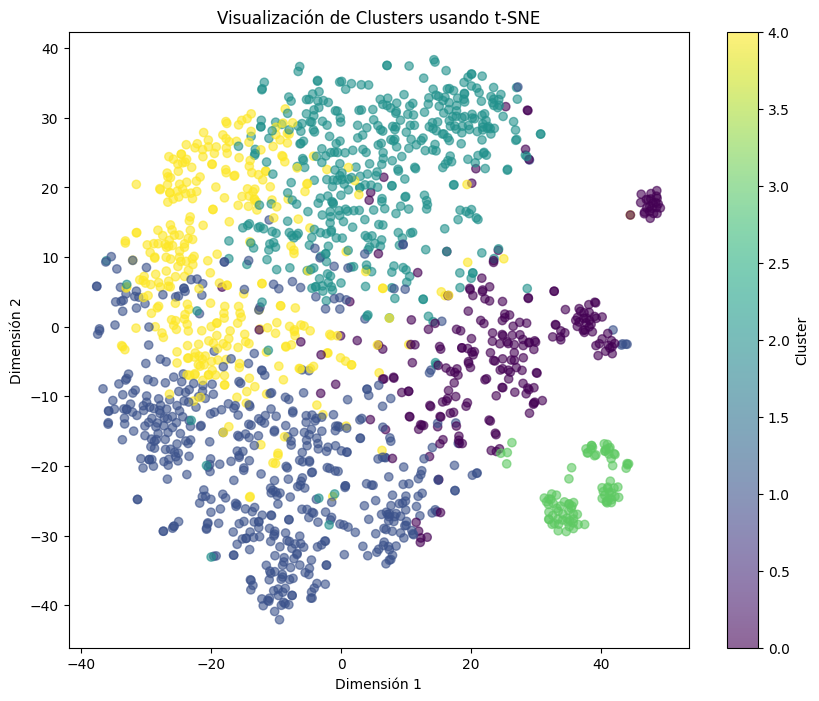


Cluster 0:
- semana fecha giro subsidio sostenimiento usuarios icetex álvaro urquijo u icetex entidad autosostenible va corrido hecho giro estudiantes temas sostenimiento valor aproximado millones peso empezando u...

- redes sociales pleno inicio semestre estudiantes icetex volvieron estallar entidad cuestionada finale año pasado deudas universidades impedían continuidad estudio varios usuarios vez jóvenes quejan in...

- redes sociales pleno inicio semestre estudiantes icetex volvieron estallar entidad cuestionada finale año pasado deudas universidades impedían continuidad estudio varios usuarios vez jóvenes quejan in...


Cluster 1:
- presidente cámara representantes jaime raúl salamanca anunció domingo febrero gobierno nacional tomó decisión citar sesiones extraordinarias discusión proyecto reforma salud encuentra segundo debate p...

- controversial consejo ministros martes pasado quedó claro malestar existe armando benedetti solo profundo sino vieja data aunque explosivos audio 

In [3]:
# 6. Reducción a 2 dimensiones para visualización con t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_reduced)

# 7. Graficar los clusters usando t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title("Visualización de Clusters usando t-SNE")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.show()

# 8. Análisis e interpretación de los clusters
for cluster_id in range(num_clusters):
    print(f"\nCluster {cluster_id}:")
    cluster_samples = df[df["cluster"] == cluster_id]["cleaned_text"].tolist()
    for sample in cluster_samples[:3]:  # Mostrar los primeros 3 textos del cluster
        print(f"- {sample[:200]}...\n")  # Mostrar solo un fragmento

<ipython-input-4-f14737fc8311>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["cluster"], palette="viridis")


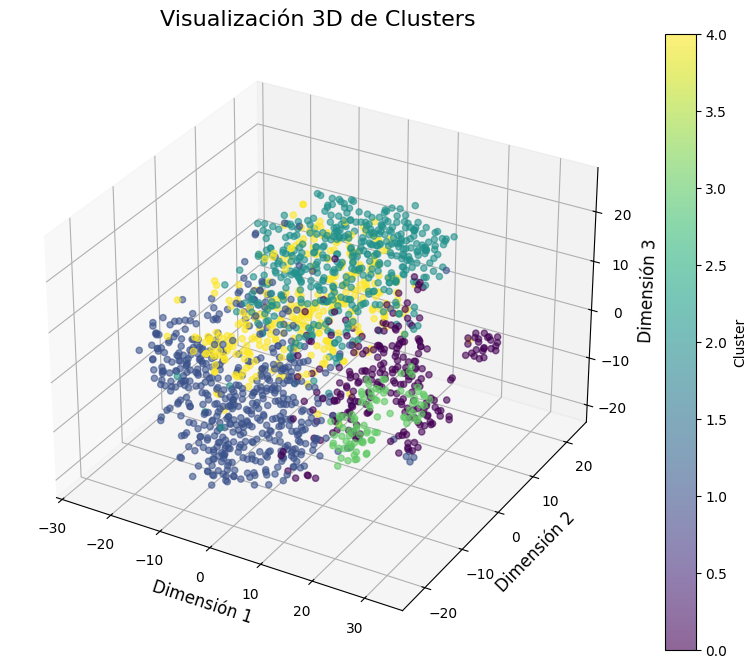

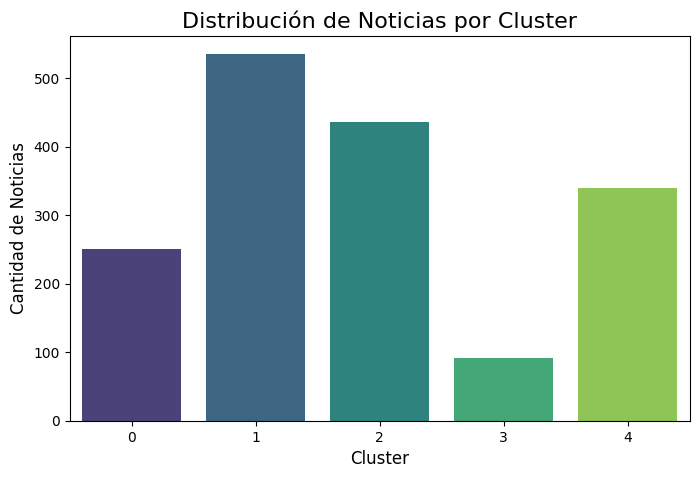

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Reducir embeddings a 3 dimensiones usando t-SNE
tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings_reduced)

# 2. Graficar en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=clusters, cmap="viridis", alpha=0.6)
plt.colorbar(scatter, label="Cluster")
ax.set_title("Visualización 3D de Clusters", fontsize=16)
ax.set_xlabel("Dimensión 1", fontsize=12)
ax.set_ylabel("Dimensión 2", fontsize=12)
ax.set_zlabel("Dimensión 3", fontsize=12)

# 3. Graficar la distribución de noticias por cluster
plt.figure(figsize=(8, 5))
sns.countplot(x=df["cluster"], palette="viridis")
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Cantidad de Noticias", fontsize=12)
plt.title("Distribución de Noticias por Cluster", fontsize=16)
plt.show()

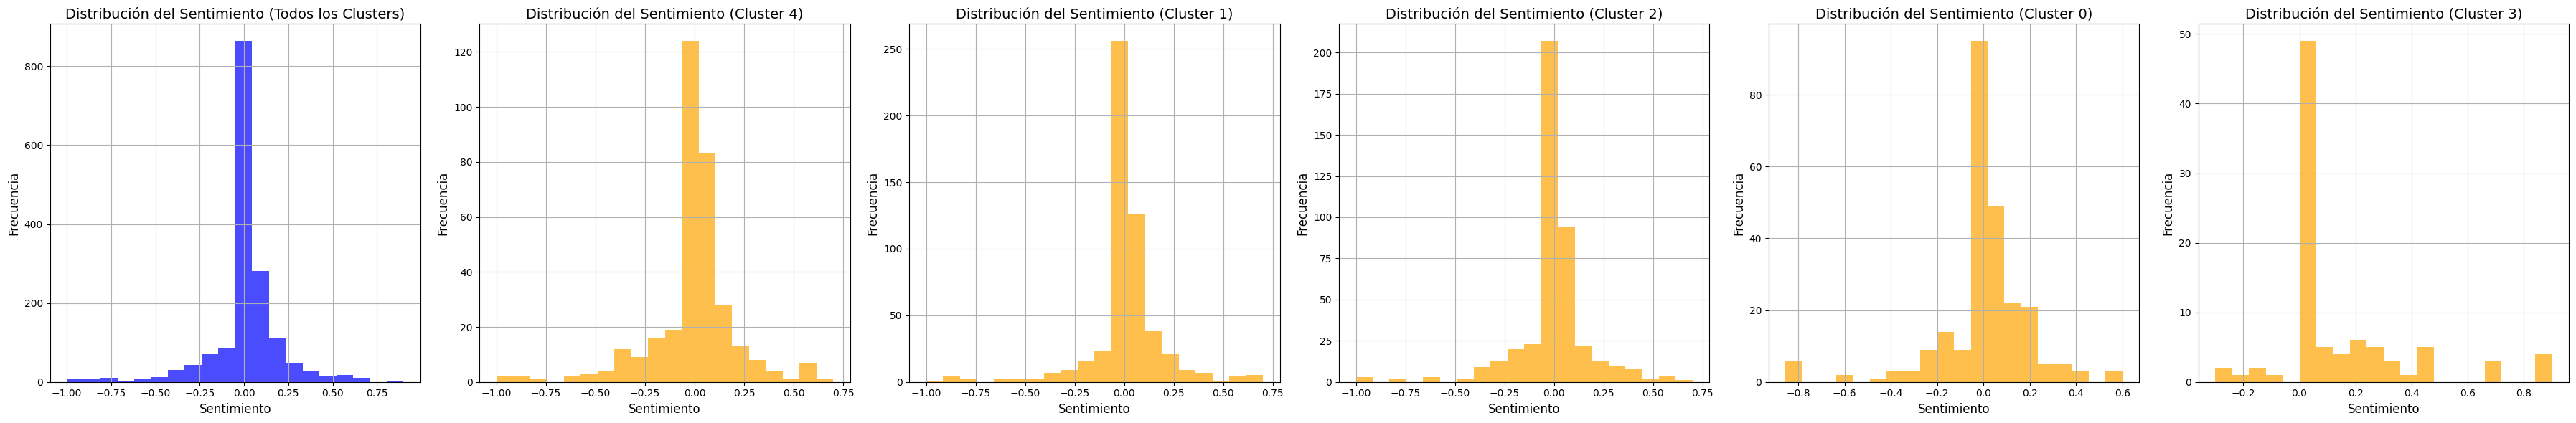

In [5]:
import matplotlib.pyplot as plt

# Obtener el número único de clusters
num_clusters = len(df_sentimientos_clusters['cluster'].unique())

# Crear una figura con subgráficos en una fila y (num_clusters + 1) columnas
# +1 para incluir el histograma general
fig, axes = plt.subplots(1, num_clusters + 1, figsize=(18, 6))  # 1 fila, (num_clusters + 1) columnas

# Ajustar el tamaño de la figura si hay muchos clusters
if num_clusters > 3:
    fig.set_size_inches(6 * (num_clusters + 1), 6)

# --- Histograma general de sentimientos ---
axes[0].hist(df_sentimientos_clusters['sentimiento'], bins=20, color='blue', alpha=0.7)
axes[0].set_title('Distribución del Sentimiento (Todos los Clusters)', fontsize=14)
axes[0].set_xlabel('Sentimiento', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].grid(True)

# --- Histogramas separados por cluster ---
for i, cluster_id in enumerate(df_sentimientos_clusters['cluster'].unique()):
    axes[i + 1].hist(df_sentimientos_clusters[df_sentimientos_clusters['cluster'] == cluster_id]['sentimiento'], bins=20, color='orange', alpha=0.7)
    axes[i + 1].set_title(f'Distribución del Sentimiento (Cluster {cluster_id})', fontsize=14)
    axes[i + 1].set_xlabel('Sentimiento', fontsize=12)
    axes[i + 1].set_ylabel('Frecuencia', fontsize=12)
    axes[i + 1].grid(True)

# Ajustar el layout para evitar superposiciones
plt.tight_layout()

# Mostrar la figura con los histogramas
plt.show()

<ipython-input-6-4eea24bb2348>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sentimientos_clusters, x='cluster', y='sentimiento', palette='coolwarm', ax=axes[0])


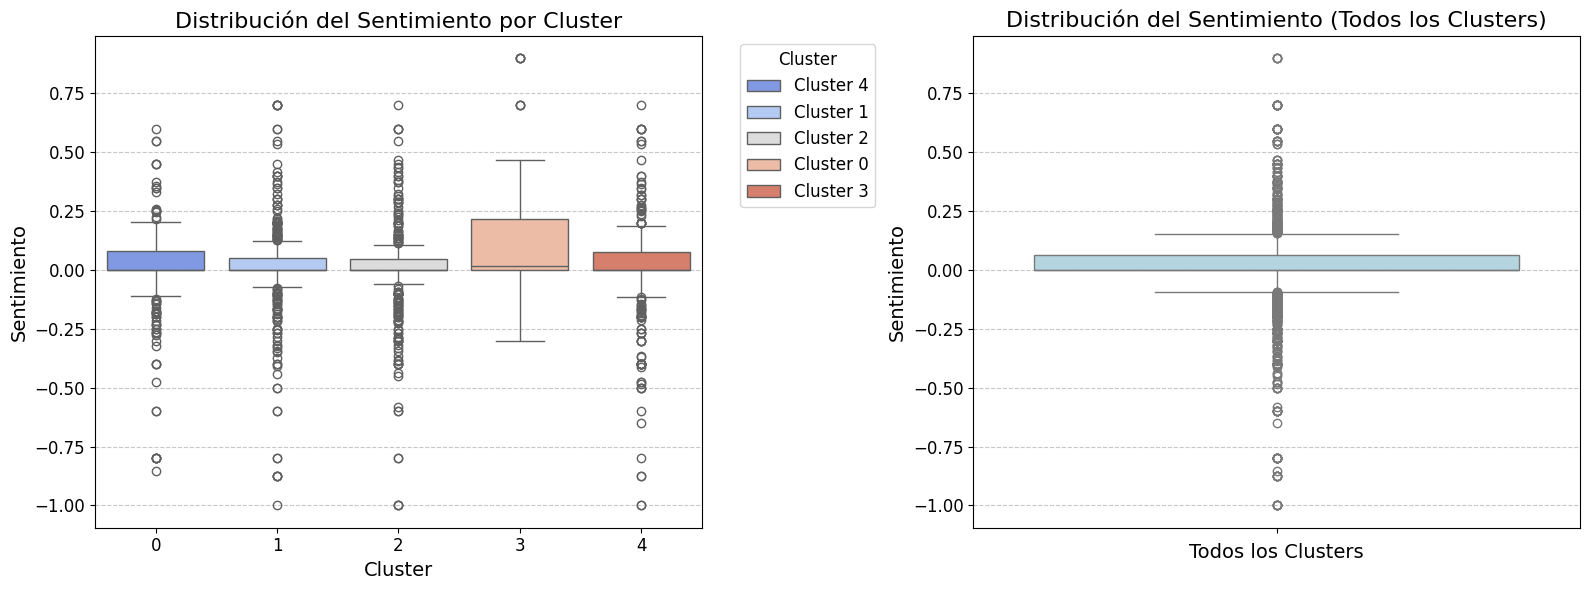

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Gráfico 1: Boxplot por cluster ---
sns.boxplot(data=df_sentimientos_clusters, x='cluster', y='sentimiento', palette='coolwarm', ax=axes[0])

# Personalizar el primer gráfico
axes[0].set_title('Distribución del Sentimiento por Cluster', fontsize=16)
axes[0].set_xlabel('Cluster', fontsize=14)
axes[0].set_ylabel('Sentimiento', fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas de color para cada cluster
for i, cluster_id in enumerate(df_sentimientos_clusters['cluster'].unique()):
    axes[0].patches[i].set_label(f'Cluster {cluster_id}')  # Asignar etiqueta a cada caja

# Mostrar la leyenda fuera del gráfico, a la derecha
axes[0].legend(title='Cluster', title_fontsize=12, fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Gráfico 2: Boxplot para todos los clusters combinados ---
sns.boxplot(data=df_sentimientos_clusters, y='sentimiento', color='lightblue', ax=axes[1])

# Personalizar el segundo gráfico
axes[1].set_title('Distribución del Sentimiento (Todos los Clusters)', fontsize=16)
axes[1].set_xlabel('Todos los Clusters', fontsize=14)
axes[1].set_ylabel('Sentimiento', fontsize=14)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar el layout para que la leyenda no se superponga
plt.tight_layout()

# Mostrar la figura
plt.show()

<ipython-input-24-ff1f2850e95e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_sentimientos, x='fuente', y='sentimiento', palette='coolwarm', ax=axes[0])


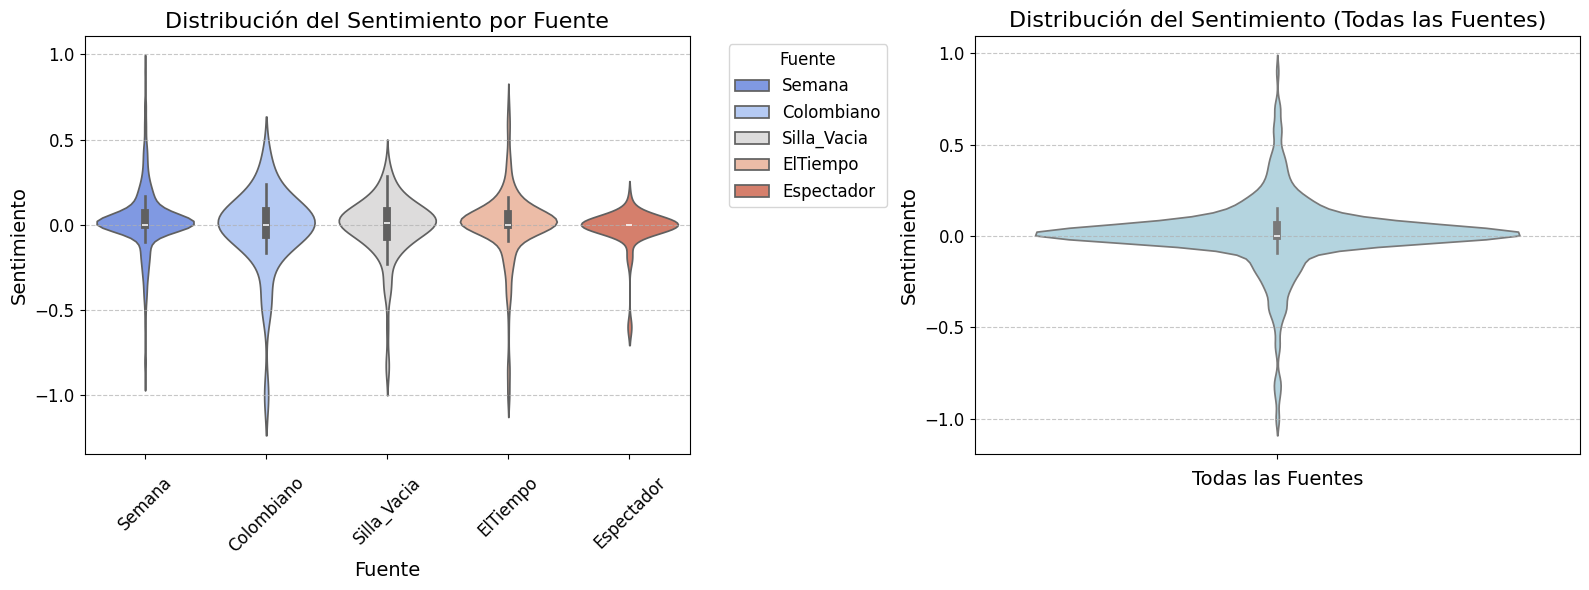

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Gráfico 1: Violin plot por fuente ---
sns.violinplot(data=df_sentimientos, x='fuente', y='sentimiento', palette='coolwarm', ax=axes[0])

# Personalizar el primer gráfico
axes[0].set_title('Distribución del Sentimiento por Fuente', fontsize=16)
axes[0].set_xlabel('Fuente', fontsize=14)
axes[0].set_ylabel('Sentimiento', fontsize=14)
axes[0].tick_params(axis='x', labelsize=12, rotation=45, pad=10)  # Rotar etiquetas y ajustar posición
axes[0].tick_params(axis='y', labelsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas de color para cada fuente
for i, fuente in enumerate(df_sentimientos['fuente'].unique()):
    axes[0].collections[i].set_label(fuente)  # Asignar etiqueta a cada violín

# Mostrar la leyenda en el primer gráfico
axes[0].legend(title='Fuente', title_fontsize=12, fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Gráfico 2: Violin plot para todas las fuentes combinadas ---
sns.violinplot(data=df_sentimientos, y='sentimiento', color='lightblue', ax=axes[1])

# Personalizar el segundo gráfico
axes[1].set_title('Distribución del Sentimiento (Todas las Fuentes)', fontsize=16)
axes[1].set_xlabel('Todas las Fuentes', fontsize=14)
axes[1].set_ylabel('Sentimiento', fontsize=14)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar el layout para que no se solapen las etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

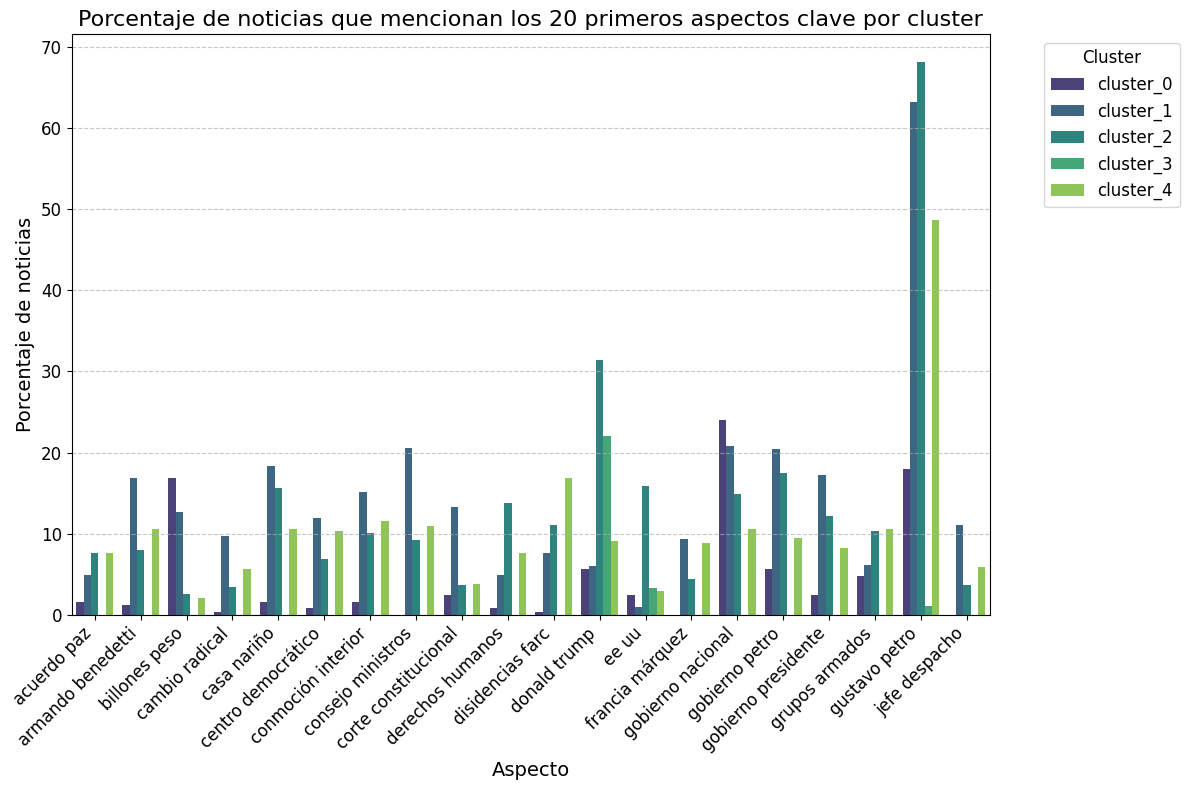

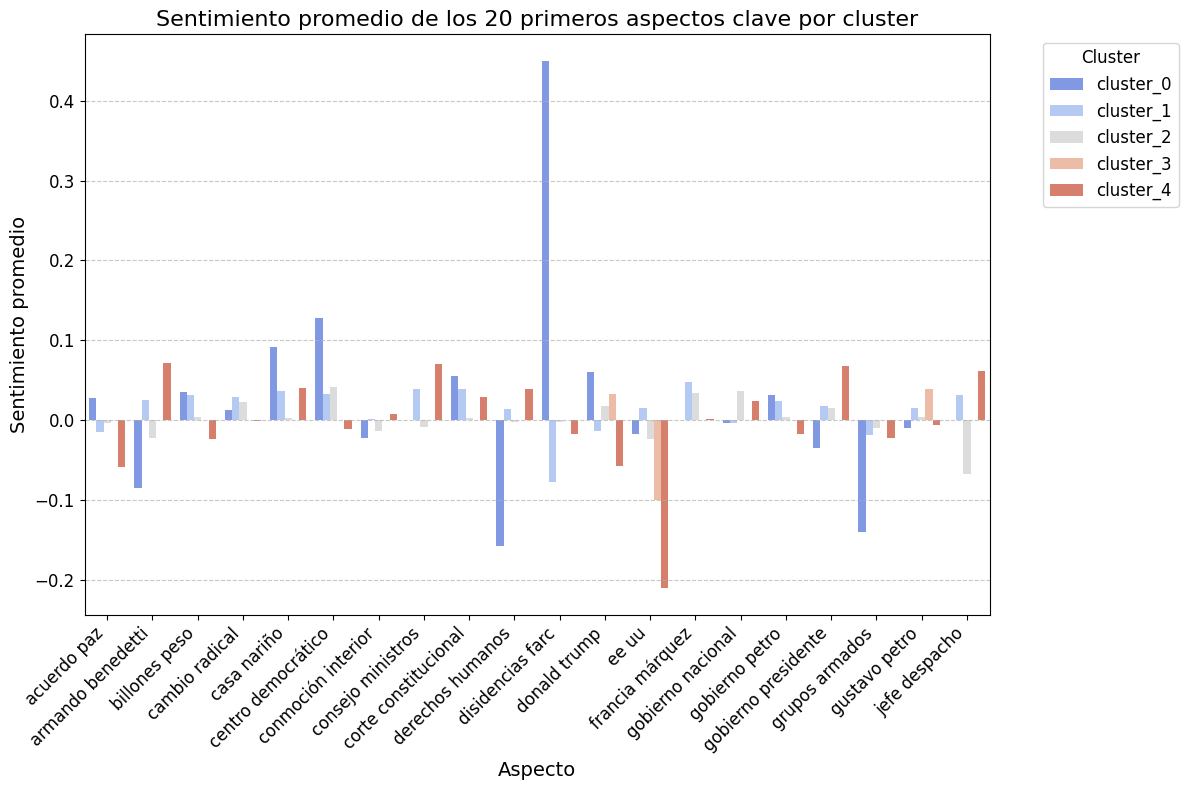

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración: número de aspectos a graficar (puedes cambiarlo a 5, 10, etc.)
num_aspectos = 20  # Cambia este valor según lo que necesites


aspectos_filtrados = [aspecto for aspecto in aspectos if aspecto not in ["cada vez", "do años", "año pasado"]]

# Seleccionar los primeros "num_aspectos" aspectos clave (usando la lista filtrada)
df_top = df_estadisticas_clusters[df_estadisticas_clusters['aspecto'].isin(aspectos_filtrados)].head(num_aspectos)

# Seleccionar los primeros "num_aspectos" aspectos clave
#df_top = df_estadisticas_clusters.head(num_aspectos)

# Reestructurar el DataFrame para Seaborn
df_top_melted_porcentaje = df_top.melt(id_vars='aspecto',
                                       value_vars=[f'cluster_{i}_porcentaje' for i in range(num_clusters)],
                                       var_name='cluster', value_name='porcentaje')
df_top_melted_sentimiento = df_top.melt(id_vars='aspecto',
                                        value_vars=[f'cluster_{i}_sentimiento' for i in range(num_clusters)],
                                        var_name='cluster', value_name='sentimiento')

# Limpiar los nombres de los clusters
df_top_melted_porcentaje['cluster'] = df_top_melted_porcentaje['cluster'].str.replace('_porcentaje', '')
df_top_melted_sentimiento['cluster'] = df_top_melted_sentimiento['cluster'].str.replace('_sentimiento', '')

# Función para graficar el porcentaje de noticias que mencionan el aspecto
def graficar_porcentaje(df_top_melted, num_aspectos):
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_top_melted, x='aspecto', y='porcentaje', hue='cluster', palette='viridis')

    # Personalizar el gráfico
    plt.title(f'Porcentaje de noticias que mencionan los {num_aspectos} primeros aspectos clave por cluster', fontsize=16)
    plt.xlabel('Aspecto', fontsize=14)
    plt.ylabel('Porcentaje de noticias', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Cluster', title_fontsize=12, fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Función para graficar el sentimiento promedio de los aspectos
def graficar_sentimiento(df_top_melted, num_aspectos):
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_top_melted, x='aspecto', y='sentimiento', hue='cluster', palette='coolwarm')

    # Personalizar el gráfico
    plt.title(f'Sentimiento promedio de los {num_aspectos} primeros aspectos clave por cluster', fontsize=16)
    plt.xlabel('Aspecto', fontsize=14)
    plt.ylabel('Sentimiento promedio', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Cluster', title_fontsize=12, fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Llamar a las funciones para graficar
graficar_porcentaje(df_top_melted_porcentaje, num_aspectos)
graficar_sentimiento(df_top_melted_sentimiento, num_aspectos)

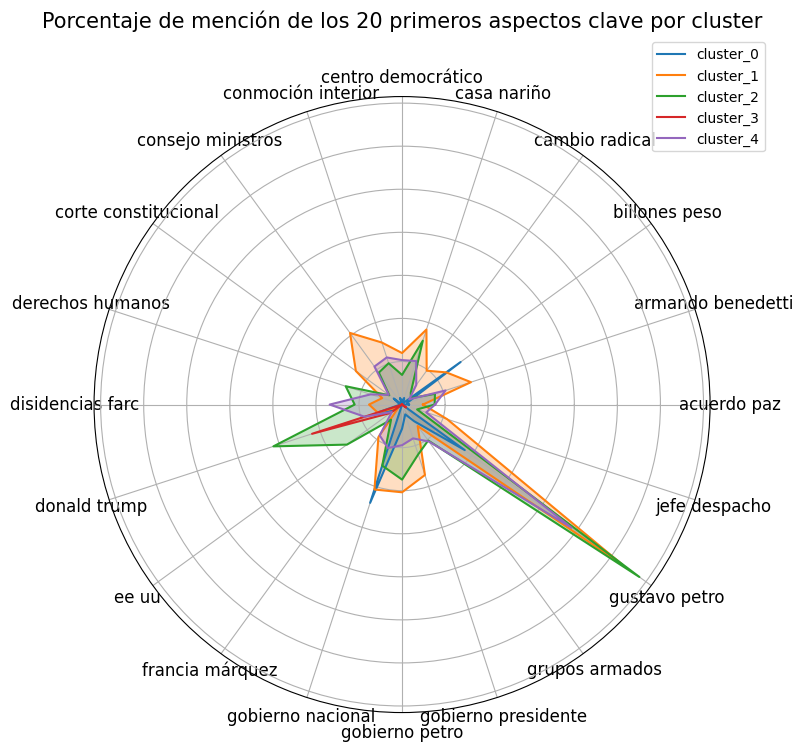

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetro para definir el número de aspectos a visualizar (puedes cambiarlo manualmente)
# num_aspectos = 10  # Cambia este valor según lo que necesites (por ejemplo, 5, 10, etc.)

# Seleccionar los primeros "num_aspectos" aspectos clave
aspectos_filtrados = [aspecto for aspecto in aspectos if aspecto not in ["cada vez", "do años", "año pasado"]]

# Seleccionar los primeros "num_aspectos" aspectos clave (usando la lista filtrada)
df_top = df_estadisticas_clusters[df_estadisticas_clusters['aspecto'].isin(aspectos_filtrados)].head(num_aspectos)
#df_top = df_estadisticas_clusters.head(num_aspectos)

# Obtener los nombres de los aspectos
aspectos = df_top['aspecto'].tolist()

# Obtener los clusters únicos
clusters = [f'cluster_{i}' for i in range(num_clusters)]

# Crear una lista para almacenar los valores de porcentaje por cluster
porcentajes_por_cluster = []

# Extraer los valores de porcentaje para cada cluster
for cluster in clusters:
    porcentajes = df_top[f'{cluster}_porcentaje'].tolist()
    porcentajes_por_cluster.append(porcentajes)

# Número de variables (aspectos)
num_vars = len(aspectos)

# Ángulos para cada eje en el gráfico de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# La gráfica de radar debe ser circular, por lo que necesitamos "cerrar" el círculo
porcentajes_por_cluster = [np.append(p, p[0]) for p in porcentajes_por_cluster]
angles += angles[:1]

# Inicializar el gráfico de radar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Dibujar cada cluster en el gráfico de radar
for i, cluster in enumerate(clusters):
    ax.plot(angles, porcentajes_por_cluster[i], label=cluster)
    ax.fill(angles, porcentajes_por_cluster[i], alpha=0.25)

# Añadir etiquetas a cada eje (aspectos)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(aspectos, fontsize=12)

# Añadir título y leyenda
plt.title(f'Porcentaje de mención de los {num_aspectos} primeros aspectos clave por cluster', size=15, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Mostrar el gráfico
plt.show()

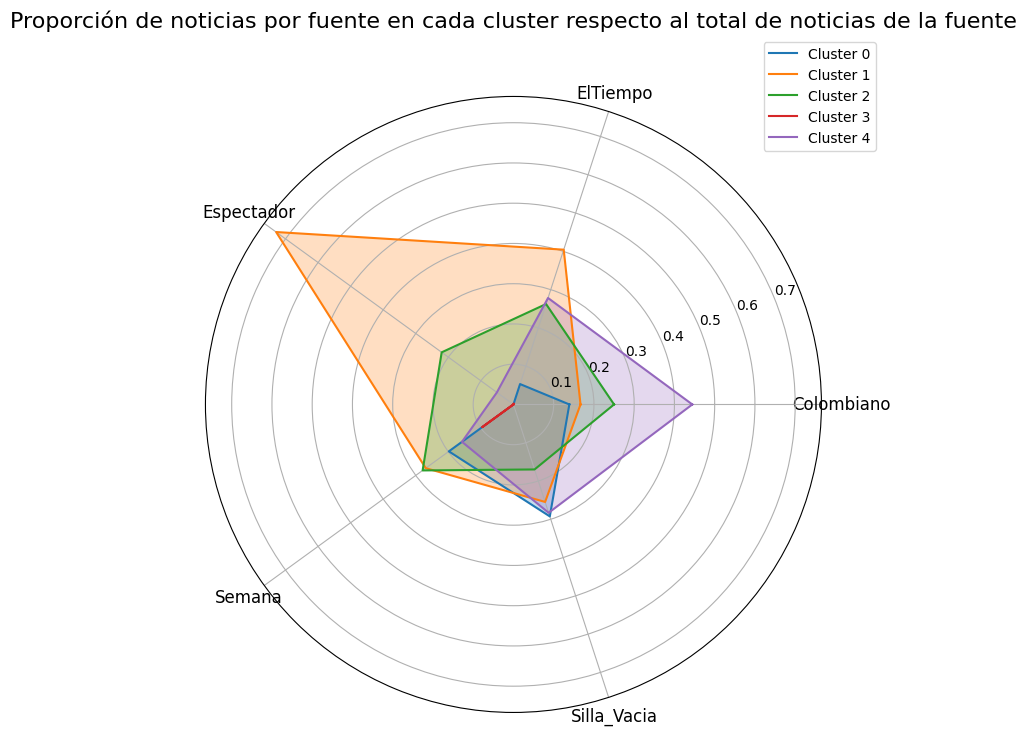

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Calcular el número de noticias por fuente en cada cluster
cluster_fuente = df.groupby(['cluster', 'fuente']).size().unstack(fill_value=0)

# 2. Calcular el número total de noticias por fuente en todas las noticias fusionadas
total_noticias_fuente = df['fuente'].value_counts()

# 3. Calcular la proporción de noticias por fuente en cada cluster respecto al total de noticias de esa fuente
proporcion_cluster_fuente = cluster_fuente.div(total_noticias_fuente, axis=1)

# Obtener las fuentes y los clusters
fuentes = proporcion_cluster_fuente.columns
clusters = proporcion_cluster_fuente.index

# 4. Crear el gráfico radial (radar)
# Número de variables (fuentes)
num_vars = len(fuentes)

# Ángulos para cada eje en el gráfico de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Cerrar el círculo

# Inicializar el gráfico de radar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Dibujar cada cluster en el gráfico de radar
for cluster in clusters:
    valores = proporcion_cluster_fuente.loc[cluster].tolist()
    valores += valores[:1]  # Cerrar el círculo
    ax.plot(angles, valores, label=f'Cluster {cluster}')
    ax.fill(angles, valores, alpha=0.25)

# Añadir etiquetas a cada eje
ax.set_xticks(angles[:-1])
ax.set_xticklabels(fuentes, fontsize=12)

# Añadir título
plt.title('Proporción de noticias por fuente en cada cluster respecto al total de noticias de la fuente', size=16, y=1.1)

# Añadir leyenda
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Mostrar el gráfico
plt.show()

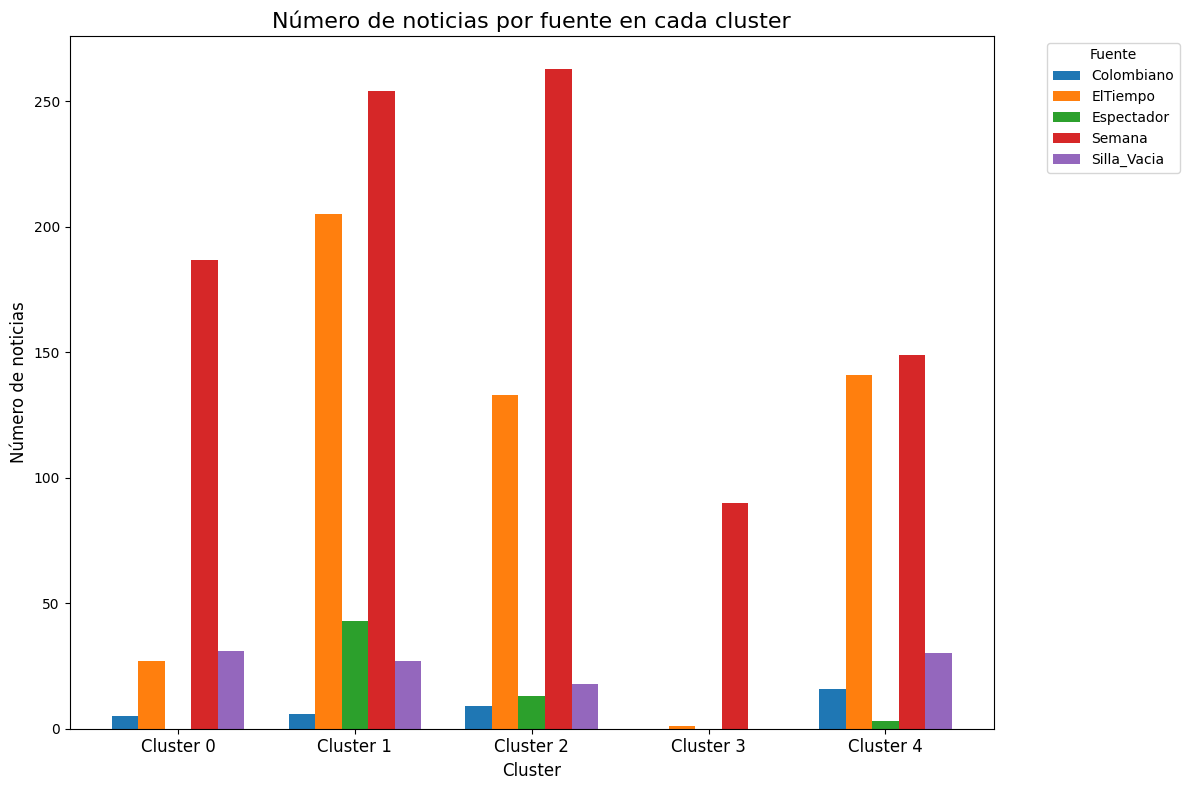

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Agrupar los datos por cluster y fuente
cluster_fuente = df.groupby(['cluster', 'fuente']).size().unstack(fill_value=0)

# Obtener las fuentes y los clusters
fuentes = cluster_fuente.columns
clusters = cluster_fuente.index

# Configurar el gráfico de barras
fig, ax = plt.subplots(figsize=(12, 8))

# Ancho de las barras
ancho_barra = 0.15

# Posiciones en el eje x para cada cluster
x = np.arange(len(clusters))

# Dibujar las barras para cada fuente
for i, fuente in enumerate(fuentes):
    ax.bar(x + i * ancho_barra, cluster_fuente[fuente], width=ancho_barra, label=fuente)

# Añadir etiquetas a los ejes
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Número de noticias', fontsize=12)

# Añadir título
ax.set_title('Número de noticias por fuente en cada cluster', fontsize=16)

# Añadir etiquetas en el eje x
ax.set_xticks(x + (len(fuentes) - 1) * ancho_barra / 2)
ax.set_xticklabels([f'Cluster {cluster}' for cluster in clusters], fontsize=12)

# Añadir leyenda
ax.legend(title='Fuente', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el layout para que no se solapen las etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

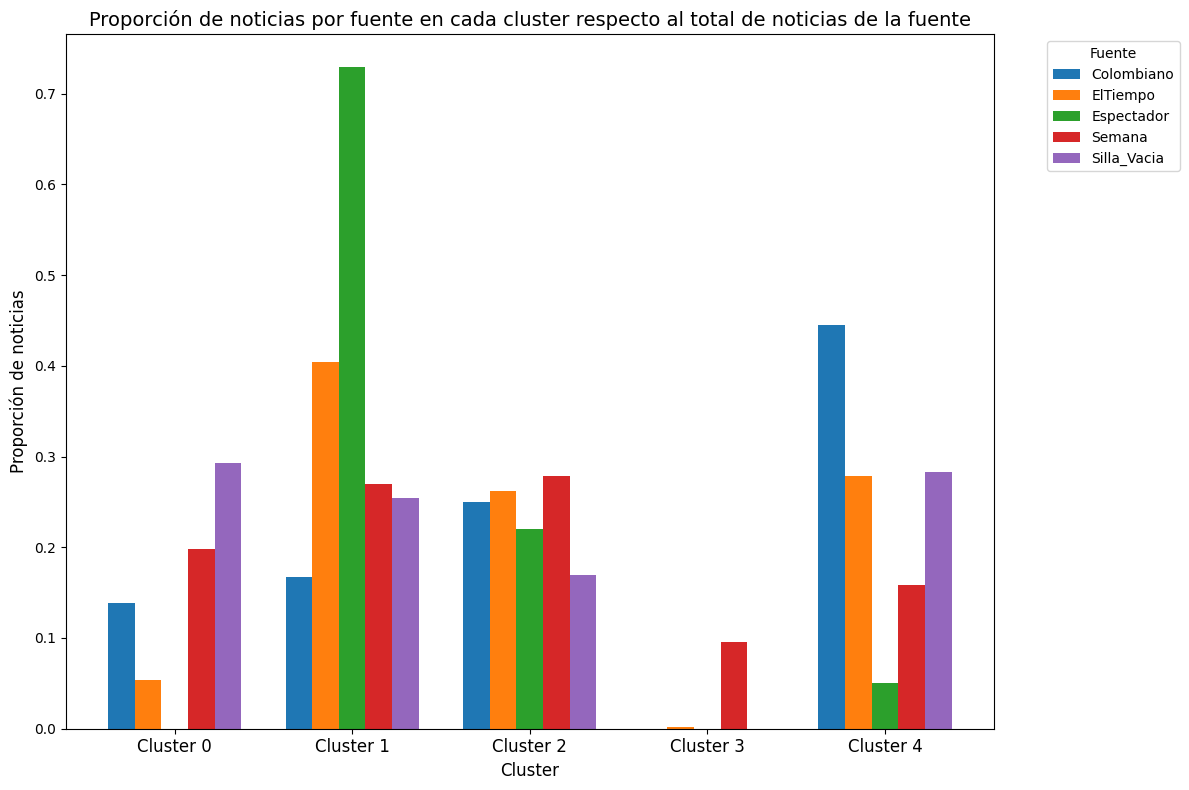

In [17]:
# Calcular el número de noticias por fuente en cada cluster
cluster_fuente = df.groupby(['cluster', 'fuente']).size().unstack(fill_value=0)

# Calcular el número total de noticias por fuente en todos los clusters
total_noticias_fuente = df['fuente'].value_counts()

# Calcular la proporción de noticias por fuente en cada cluster respecto al total de noticias de esa fuente
proporcion_cluster_fuente = cluster_fuente.div(total_noticias_fuente, axis=1)

# Obtener las fuentes y los clusters
fuentes = proporcion_cluster_fuente.columns
clusters = proporcion_cluster_fuente.index

# Configurar el gráfico de barras
fig, ax = plt.subplots(figsize=(12, 8))

# Ancho de las barras
ancho_barra = 0.15

# Posiciones en el eje x para cada cluster
x = np.arange(len(clusters))

# Dibujar las barras para cada fuente
for i, fuente in enumerate(fuentes):
    ax.bar(x + i * ancho_barra, proporcion_cluster_fuente[fuente], width=ancho_barra, label=fuente)

# Añadir etiquetas a los ejes
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Proporción de noticias', fontsize=12)

# Añadir título
ax.set_title('Proporción de noticias por fuente en cada cluster respecto al total de noticias de la fuente', fontsize=14)

# Añadir etiquetas en el eje x
ax.set_xticks(x + (len(fuentes) - 1) * ancho_barra / 2)
ax.set_xticklabels([f'Cluster {cluster}' for cluster in clusters], fontsize=12)

# Añadir leyenda
ax.legend(title='Fuente', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el layout para que no se solapen las etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [29]:
# Calcular la cantidad de noticias por fuente
cantidad_noticias_fuente = df['fuente'].value_counts().reset_index()

# Renombrar las columnas del DataFrame
cantidad_noticias_fuente.columns = ['fuente', 'cantidad_noticias']

# Mostrar el DataFrame
# cantidad_noticias_fuente

<ipython-input-28-4275f2d79405>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=cantidad_noticias_fuente, x='fuente', y='cantidad_noticias', palette='viridis')


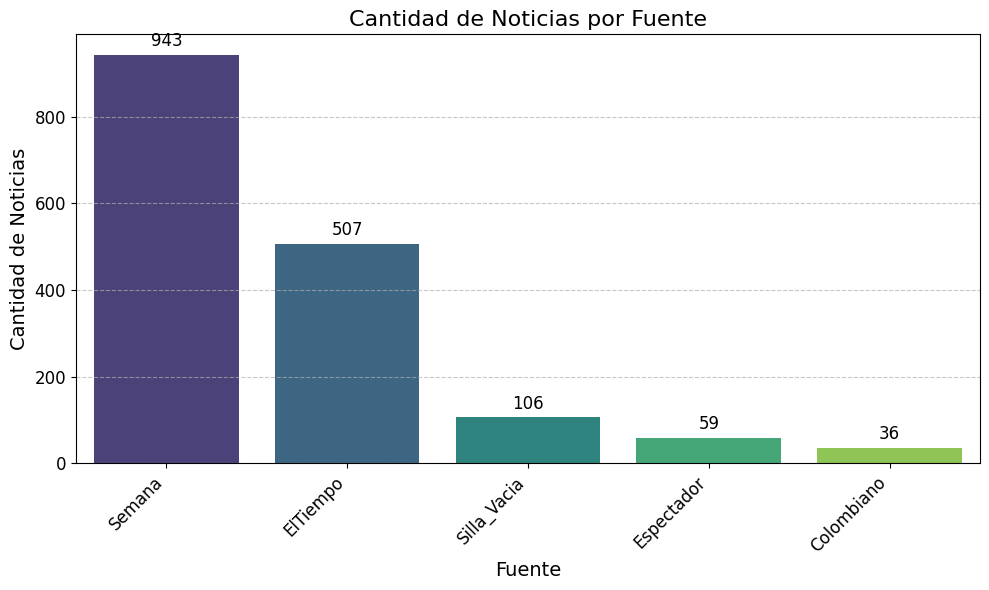

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=cantidad_noticias_fuente, x='fuente', y='cantidad_noticias', palette='viridis')

# Personalizar el gráfico
plt.title('Cantidad de Noticias por Fuente', fontsize=16)
plt.xlabel('Fuente', fontsize=14)
plt.ylabel('Cantidad de Noticias', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotar etiquetas del eje x para mejor legibilidad
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir el número de noticias encima de cada barra
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',  # Texto a mostrar (altura de la barra)
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Posición del texto
        ha='center',  # Alineación horizontal centrada
        va='center',  # Alineación vertical centrada
        fontsize=12,  # Tamaño de la fuente
        color='black',  # Color del texto
        xytext=(0, 10),  # Desplazamiento del texto respecto a la posición
        textcoords='offset points'  # Sistema de coordenadas para el desplazamiento
    )

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Analisis por fuentes

In [9]:
# Imprimir la tabla de infomracion
print("\nTabla de informacion:")
df_informacion


Tabla de informacion:


,fuente,aspectos,sentimiento_noticia,cluster
0,Semana,"[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (...",0.116667,4
1,Semana,"[(1, -0.19444444444444442, 0.8333333333333334)...",-0.194444,4
2,Semana,"[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (...",0.000000,1
3,Semana,"[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (...",0.466667,4
4,Semana,"[(0, 0, 0), (1, 0.275, 0.6), (0, 0, 0), (0, 0,...",0.275000,1
...,...,...,...,...
1646,ElTiempo,"[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (...",0.000000,4
1647,ElTiempo,"[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (...",-0.194444,2
1648,ElTiempo,"[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (...",0.000000,4
1649,ElTiempo,"[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (...",0.140476,1


In [10]:
# Imprimir la tabla de estadísticas
print("\nTabla de aspectos clave principales:")
df_estadisticas


Tabla de aspectos clave principales:


,aspecto,Semana_porcentaje,Semana_sentimiento,Semana_subjetividad,Semana_subjetividad_general,Colombiano_porcentaje,Colombiano_sentimiento,Colombiano_subjetividad,Colombiano_subjetividad_general,Silla_Vacia_porcentaje,...,Silla_Vacia_subjetividad,Silla_Vacia_subjetividad_general,ElTiempo_porcentaje,ElTiempo_sentimiento,ElTiempo_subjetividad,ElTiempo_subjetividad_general,Espectador_porcentaje,Espectador_sentimiento,Espectador_subjetividad,Espectador_subjetividad_general
0,acuerdo paz,2.757158,-0.053920,0.458958,-0.053920,8.333333,-0.102407,0.347685,-0.102407,6.603774,...,0.322934,-0.050530,9.861933,0.006690,0.441236,0.006690,5.084746,-0.063889,0.359722,-0.063889
1,armando benedetti,8.907741,0.049688,0.345496,0.049688,5.555556,-0.083333,0.383333,-0.083333,7.547170,...,0.566230,0.005467,11.637081,-0.003793,0.347551,-0.003793,18.644068,0.000000,0.136364,0.000000
2,año pasado,6.998940,0.037666,0.461697,0.037666,8.333333,0.016667,0.550000,0.016667,8.490566,...,0.409427,-0.012696,9.467456,-0.028993,0.429343,-0.028993,3.389831,-0.086111,0.422222,-0.086111
3,billones peso,9.650053,0.020233,0.468825,0.020233,5.555556,0.083333,0.409524,0.083333,2.830189,...,0.385281,0.112584,6.311637,0.036582,0.388293,0.036582,0.000000,0.000000,0.000000,0.000000
4,cada vez,6.574761,-0.004828,0.444322,-0.004828,22.222222,0.009375,0.368527,0.009375,26.415094,...,0.425890,0.001841,5.917160,0.030469,0.434155,0.030469,0.000000,0.000000,0.000000,0.000000
5,cambio radical,3.075292,-0.030265,0.347656,-0.030265,0.000000,0.000000,0.000000,0.000000,1.886792,...,0.547569,-0.077083,10.650888,0.052587,0.354562,0.052587,3.389831,0.000000,0.100000,0.000000
6,casa nariño,13.573701,0.028299,0.356953,0.028299,11.111111,0.018750,0.226042,0.018750,5.660377,...,0.635567,-0.025087,12.228797,0.032947,0.327339,0.032947,10.169492,-0.003704,0.440741,-0.003704
7,centro democrático,6.574761,0.010277,0.352575,0.010277,0.000000,0.000000,0.000000,0.000000,2.830189,...,0.487639,-0.027500,11.834320,0.044216,0.356602,0.044216,10.169492,0.000000,0.191667,0.000000
8,conmoción interior,11.240721,0.013160,0.357803,0.013160,11.111111,-0.005000,0.370240,-0.005000,2.830189,...,0.476389,-0.094345,9.664694,-0.028387,0.383546,-0.028387,10.169492,0.008333,0.083333,0.008333
9,consejo ministros,10.180276,0.072377,0.331387,0.072377,16.666667,-0.114815,0.382870,-0.114815,6.603774,...,0.585754,-0.040785,14.201183,0.005086,0.329592,0.005086,10.169492,0.041667,0.241667,0.041667


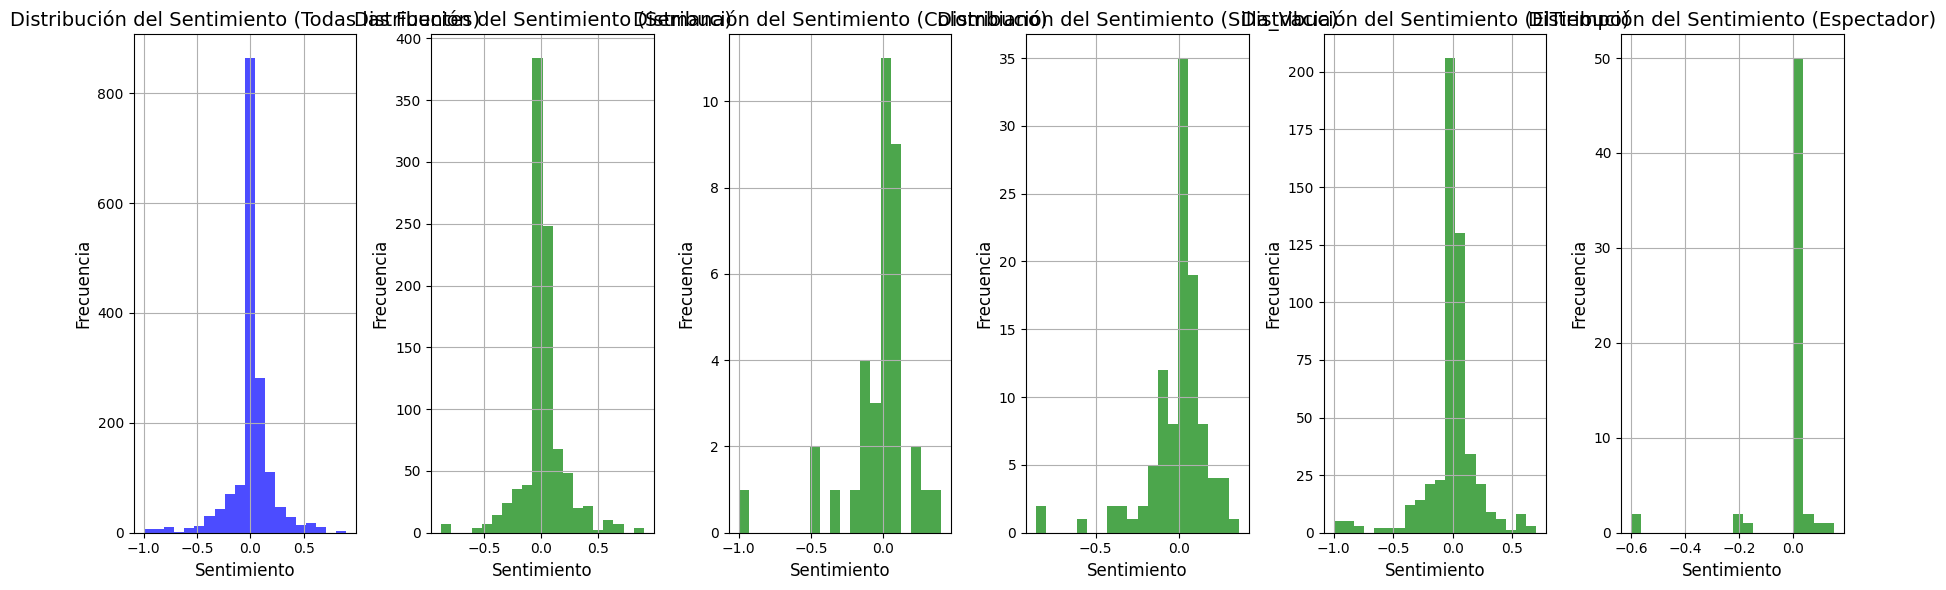

In [11]:
import matplotlib.pyplot as plt

# Obtener el número de fuentes únicas
num_fuentes = len(df_sentimientos['fuente'].unique())

# Crear una figura con subgráficos en una fila y (num_fuentes + 1) columnas
fig, axes = plt.subplots(1, num_fuentes + 1, figsize=(18, 6))  # 1 fila, (num_fuentes + 1) columnas

# --- Histograma general de sentimientos ---
axes[0].hist(df_sentimientos['sentimiento'], bins=20, color='blue', alpha=0.7)
axes[0].set_title('Distribución del Sentimiento (Todas las Fuentes)', fontsize=14)
axes[0].set_xlabel('Sentimiento', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].grid(True)

# --- Histogramas separados por fuente ---
for i, fuente in enumerate(df_sentimientos['fuente'].unique()):
    axes[i + 1].hist(df_sentimientos[df_sentimientos['fuente'] == fuente]['sentimiento'], bins=20, color='green', alpha=0.7)
    axes[i + 1].set_title(f'Distribución del Sentimiento ({fuente})', fontsize=14)
    axes[i + 1].set_xlabel('Sentimiento', fontsize=12)
    axes[i + 1].set_ylabel('Frecuencia', fontsize=12)
    axes[i + 1].grid(True)

# Ajustar el layout para evitar superposiciones
plt.tight_layout()

# Mostrar la figura con los histogramas
plt.show()

<ipython-input-12-5b06897b20a5>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sentimientos, x='fuente', y='sentimiento', palette='coolwarm', ax=axes[0])


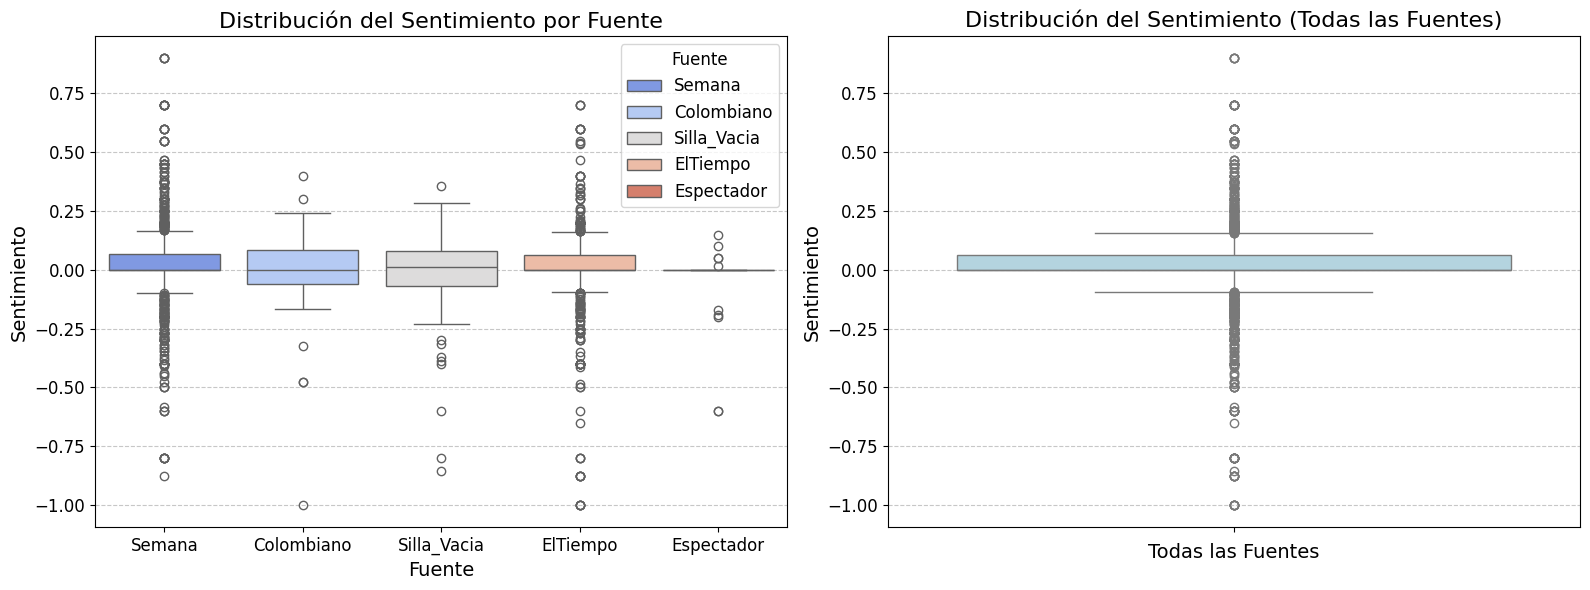

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Gráfico 1: Boxplot por fuente ---
sns.boxplot(data=df_sentimientos, x='fuente', y='sentimiento', palette='coolwarm', ax=axes[0])

# Personalizar el primer gráfico
axes[0].set_title('Distribución del Sentimiento por Fuente', fontsize=16)
axes[0].set_xlabel('Fuente', fontsize=14)
axes[0].set_ylabel('Sentimiento', fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas de color para cada fuente
for i, fuente in enumerate(df_sentimientos['fuente'].unique()):
    axes[0].patches[i].set_label(fuente)  # Asignar etiqueta a cada caja

# Mostrar la leyenda en el primer gráfico
axes[0].legend(title='Fuente', title_fontsize=12, fontsize=12)

# --- Gráfico 2: Boxplot para todas las fuentes combinadas ---
sns.boxplot(data=df_sentimientos, y='sentimiento', color='lightblue', ax=axes[1])

# Personalizar el segundo gráfico
axes[1].set_title('Distribución del Sentimiento (Todas las Fuentes)', fontsize=16)
axes[1].set_xlabel('Todas las Fuentes', fontsize=14)
axes[1].set_ylabel('Sentimiento', fontsize=14)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar el layout
plt.tight_layout()
plt.show()

<ipython-input-23-ff1f2850e95e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_sentimientos, x='fuente', y='sentimiento', palette='coolwarm', ax=axes[0])


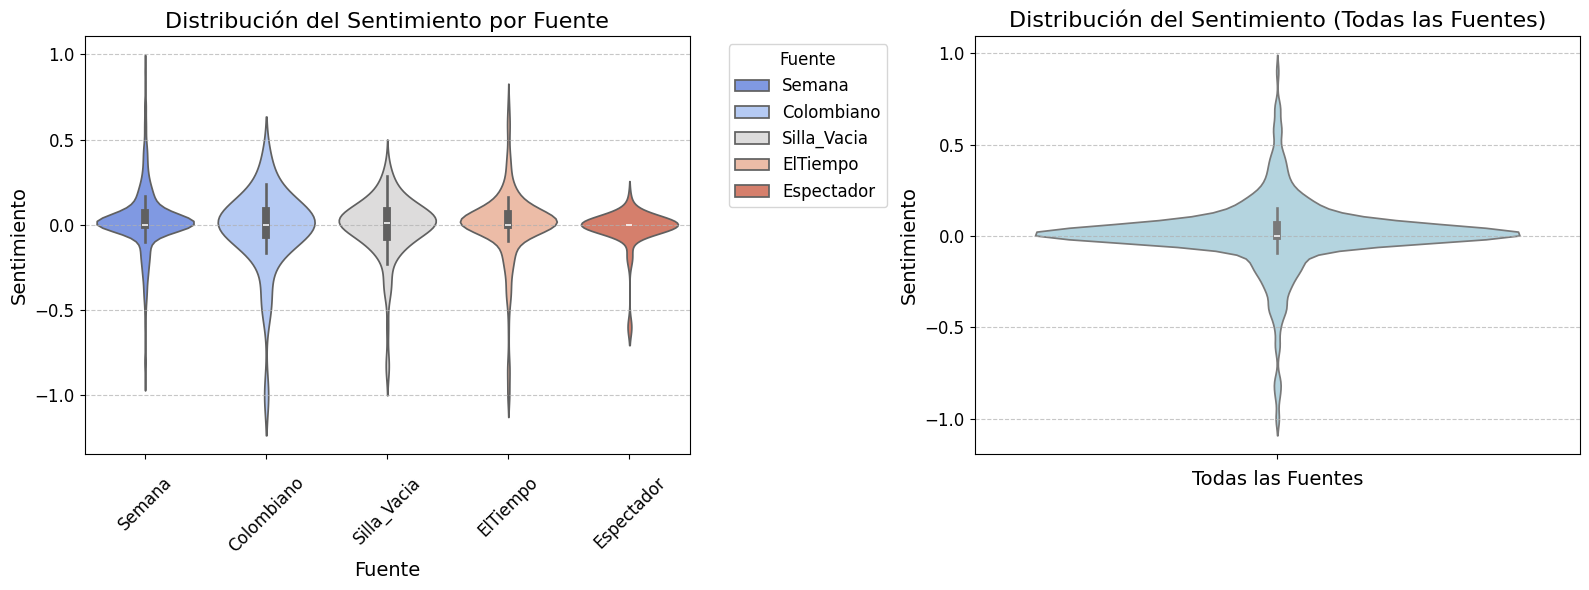

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Gráfico 1: Violin plot por fuente ---
sns.violinplot(data=df_sentimientos, x='fuente', y='sentimiento', palette='coolwarm', ax=axes[0])

# Personalizar el primer gráfico
axes[0].set_title('Distribución del Sentimiento por Fuente', fontsize=16)
axes[0].set_xlabel('Fuente', fontsize=14)
axes[0].set_ylabel('Sentimiento', fontsize=14)
axes[0].tick_params(axis='x', labelsize=12, rotation=45, pad=10)  # Rotar etiquetas y ajustar posición
axes[0].tick_params(axis='y', labelsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas de color para cada fuente
for i, fuente in enumerate(df_sentimientos['fuente'].unique()):
    axes[0].collections[i].set_label(fuente)  # Asignar etiqueta a cada violín

# Mostrar la leyenda en el primer gráfico
axes[0].legend(title='Fuente', title_fontsize=12, fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Gráfico 2: Violin plot para todas las fuentes combinadas ---
sns.violinplot(data=df_sentimientos, y='sentimiento', color='lightblue', ax=axes[1])

# Personalizar el segundo gráfico
axes[1].set_title('Distribución del Sentimiento (Todas las Fuentes)', fontsize=16)
axes[1].set_xlabel('Todas las Fuentes', fontsize=14)
axes[1].set_ylabel('Sentimiento', fontsize=14)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar el layout para que no se solapen las etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

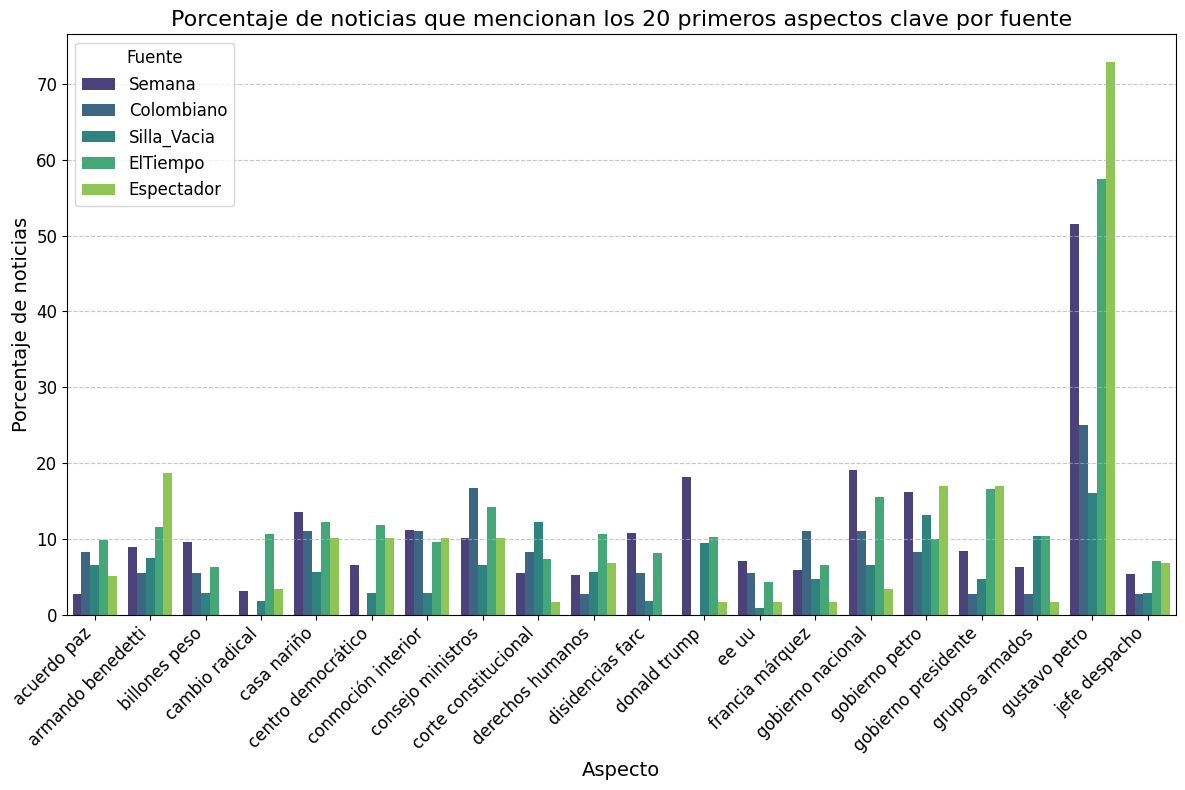

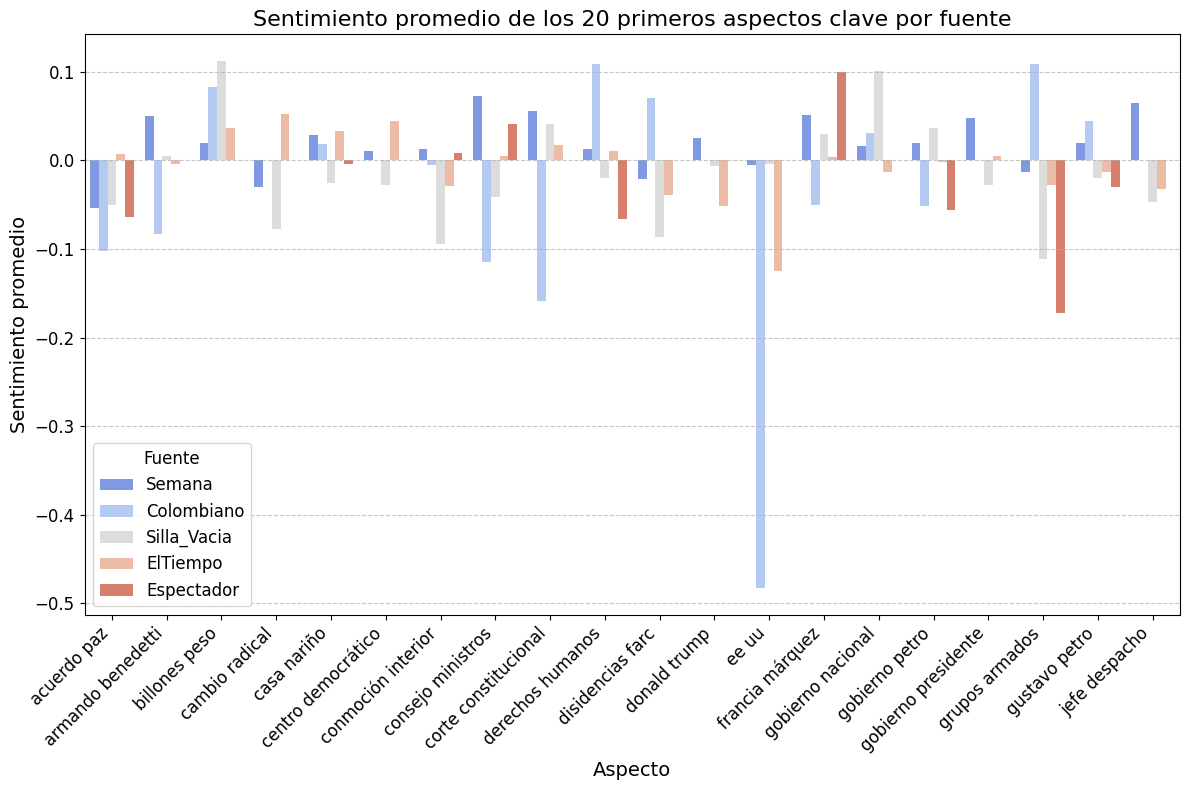

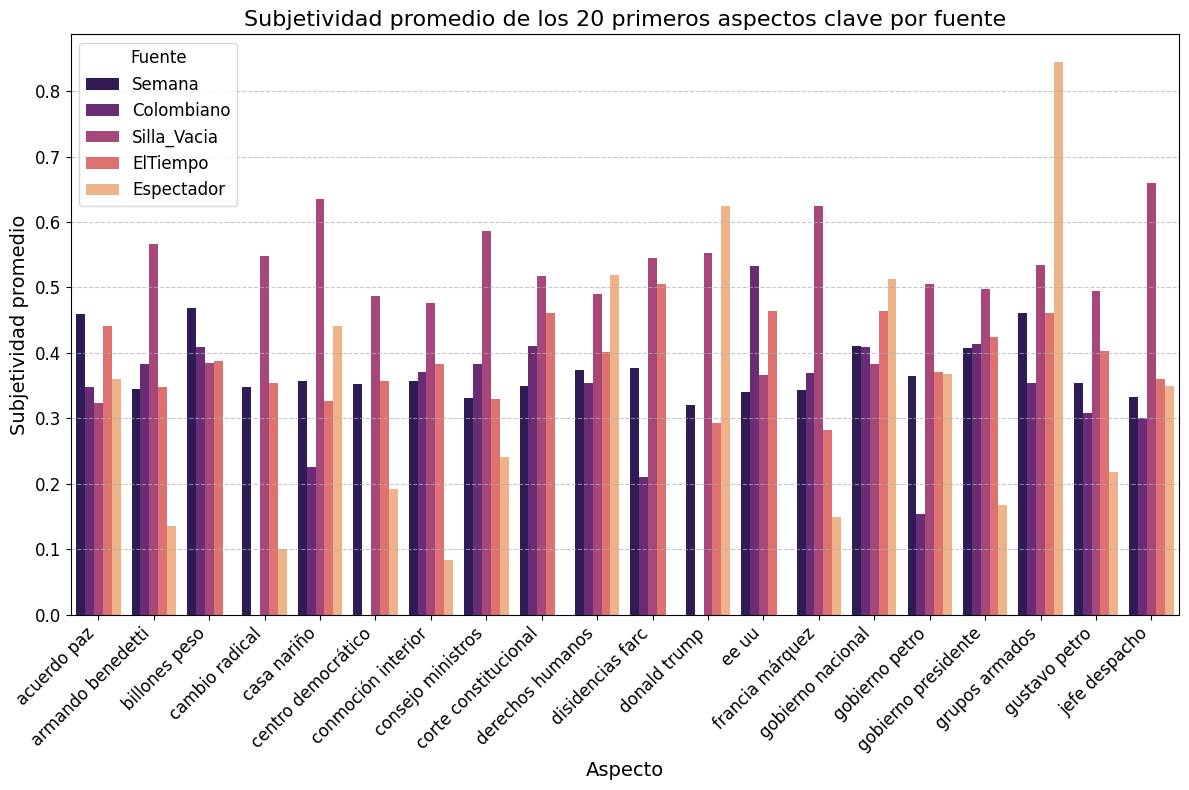

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración: número de aspectos a graficar (puedes cambiarlo a 5, 10, etc.)
num_aspectos = 20  # Cambia este valor según lo que necesites

# Seleccionar los primeros "num_aspectos" aspectos clave
aspectos_filtrados = [aspecto for aspecto in aspectos if aspecto not in ["cada vez", "do años", "año pasado"]]

# Seleccionar los primeros "num_aspectos" aspectos clave (usando la lista filtrada)
df_top = df_estadisticas[df_estadisticas['aspecto'].isin(aspectos_filtrados)].head(num_aspectos)
#df_top = df_estadisticas.head(num_aspectos)

# Identificar automáticamente las columnas de porcentaje, sentimiento y subjetividad por fuente
columnas_porcentaje = [col for col in df_top.columns if col.endswith('_porcentaje')]
columnas_sentimiento = [col for col in df_top.columns if col.endswith('_sentimiento')]
columnas_subjetividad = [col for col in df_top.columns if col.endswith('_subjetividad')]

# Reestructurar el DataFrame para Seaborn
df_top_melted_porcentaje = df_top.melt(id_vars='aspecto', value_vars=columnas_porcentaje,
                                       var_name='fuente', value_name='porcentaje')
df_top_melted_sentimiento = df_top.melt(id_vars='aspecto', value_vars=columnas_sentimiento,
                                        var_name='fuente', value_name='sentimiento')
df_top_melted_subjetividad = df_top.melt(id_vars='aspecto', value_vars=columnas_subjetividad,
                                         var_name='fuente', value_name='subjetividad')

# Limpiar los nombres de las fuentes
df_top_melted_porcentaje['fuente'] = df_top_melted_porcentaje['fuente'].str.replace('_porcentaje', '')
df_top_melted_sentimiento['fuente'] = df_top_melted_sentimiento['fuente'].str.replace('_sentimiento', '')
df_top_melted_subjetividad['fuente'] = df_top_melted_subjetividad['fuente'].str.replace('_subjetividad', '')

# Función para graficar el porcentaje de noticias que mencionan el aspecto
def graficar_porcentaje(df_top_melted, num_aspectos):
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_top_melted, x='aspecto', y='porcentaje', hue='fuente', palette='viridis')

    # Personalizar el gráfico
    plt.title(f'Porcentaje de noticias que mencionan los {num_aspectos} primeros aspectos clave por fuente', fontsize=16)
    plt.xlabel('Aspecto', fontsize=14)
    plt.ylabel('Porcentaje de noticias', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Fuente', title_fontsize=12, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Función para graficar el sentimiento promedio de los aspectos
def graficar_sentimiento(df_top_melted, num_aspectos):
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_top_melted, x='aspecto', y='sentimiento', hue='fuente', palette='coolwarm')

    # Personalizar el gráfico
    plt.title(f'Sentimiento promedio de los {num_aspectos} primeros aspectos clave por fuente', fontsize=16)
    plt.xlabel('Aspecto', fontsize=14)
    plt.ylabel('Sentimiento promedio', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Fuente', title_fontsize=12, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Función para graficar la subjetividad promedio de los aspectos
def graficar_subjetividad(df_top_melted, num_aspectos):
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_top_melted, x='aspecto', y='subjetividad', hue='fuente', palette='magma')

    # Personalizar el gráfico
    plt.title(f'Subjetividad promedio de los {num_aspectos} primeros aspectos clave por fuente', fontsize=16)
    plt.xlabel('Aspecto', fontsize=14)
    plt.ylabel('Subjetividad promedio', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Fuente', title_fontsize=12, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Llamar a las funciones para graficar
graficar_porcentaje(df_top_melted_porcentaje, num_aspectos)
graficar_sentimiento(df_top_melted_sentimiento, num_aspectos)
graficar_subjetividad(df_top_melted_subjetividad, num_aspectos)

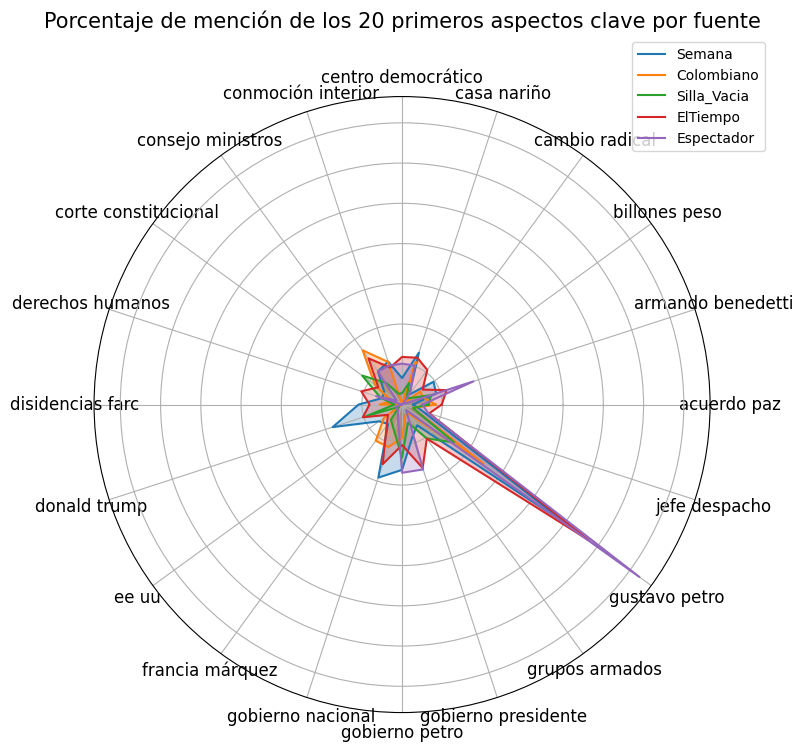

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetro para definir el número de aspectos a visualizar (puedes cambiarlo manualmente)
#num_aspectos = 10  # Cambia este valor según lo que necesites (por ejemplo, 5, 10, etc.)

# Seleccionar los primeros "num_aspectos" aspectos clave
aspectos_filtrados = [aspecto for aspecto in aspectos if aspecto not in ["cada vez", "do años", "año pasado"]]

# Seleccionar los primeros "num_aspectos" aspectos clave (usando la lista filtrada)
df_top = df_estadisticas[df_estadisticas['aspecto'].isin(aspectos_filtrados)].head(num_aspectos)
#df_top = df_estadisticas.head(num_aspectos)
# Obtener los nombres de los aspectos
aspectos = df_top['aspecto'].tolist()

# Obtener las fuentes únicas (en este caso, "tiempo" y "semana")
fuentes = df['fuente'].unique()

# Crear una lista para almacenar los valores de porcentaje por fuente
porcentajes_por_fuente = []

# Extraer los valores de porcentaje para cada fuente
for fuente in fuentes:
    porcentajes = df_top[f'{fuente}_porcentaje'].tolist()
    porcentajes_por_fuente.append(porcentajes)

# Número de variables (aspectos)
num_vars = len(aspectos)

# Ángulos para cada eje en el gráfico de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# La gráfica de radar debe ser circular, por lo que necesitamos "cerrar" el círculo
porcentajes_por_fuente = [np.append(p, p[0]) for p in porcentajes_por_fuente]
angles += angles[:1]

# Inicializar el gráfico de radar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Dibujar cada fuente en el gráfico de radar
for i, fuente in enumerate(fuentes):
    ax.plot(angles, porcentajes_por_fuente[i], label=fuente)
    ax.fill(angles, porcentajes_por_fuente[i], alpha=0.25)

# Añadir etiquetas a cada eje (aspectos)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(aspectos, fontsize=12)

# Añadir título y leyenda
plt.title(f'Porcentaje de mención de los {num_aspectos} primeros aspectos clave por fuente', size=15, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Mostrar el gráfico
plt.show()